##### $\hspace{15pt}$ **Filename: sentimentAnalysis.ipynb**
##### $\hspace{1.5pt}$ **Date Created: November 6, 2024**
**Date Modified: November 8, 2024**
##### $\rule{10.5in}{1pt}$
##### **Run a sentiment analysis on a [movie reviews dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) from Kaggle by training and testing classifiers using [scikit-learn](https://scikit-learn.org/stable/index.html) and by testing a classifier using a pretrained model from [Hugging Face](https://huggingface.co/).**

##### **The file `IMDB Dataset.csv` that has to be accessed is available in this [Google Drive folder](https://drive.google.com/drive/folders/1KNRwDVDjriJ1PrPKBwAZ71RhphuBlH8g?usp=sharing). Before running this notebook in Colab, either change the path to access the file, or create the subfolder `/Colab Notebooks/019_sentimentAnalysisUsingScikit-learn` in your Google drive and copy the file to the subfolder.**

##### $\rule{10.5in}{1pt}$

##### Install `nltk`.

In [1]:
!pip install nltk -q

##### Load modules and packages.

In [2]:
from google.colab import drive
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics  import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from transformers import AutoTokenizer, pipeline
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import seaborn as sns
import string
import time
import warnings

##### Set the maximum column width of pandas dataframes.

In [3]:
pd.set_option("display.max_colwidth", 150)

##### Disable warnings.

In [4]:
warnings.filterwarnings("ignore")

##### Mount Google Drive to Colab.

In [5]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


##### Set the path to access the file needed by this notebook.

In [6]:
path = "gdrive/MyDrive/Colab Notebooks/019_sentimentAnalysisUsingScikit-learn/"

##### Load the dataset from Google Drive.

In [7]:
dataset = pd.read_csv(path + "IMDB Dataset.csv")
dataset.head()

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened ...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometim...",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted ...",positive
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />Thi...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. Thi...",positive


##### Check if there are missing values.

In [8]:
dataset.isnull().sum()

,0
review,0
sentiment,0


##### Tokenize the reviews in the dataset.

In [9]:
nltk.download("punkt")
nltk.download("stopwords")

reviews = dataset.review.str.cat(sep = " ").lower()
tokens = word_tokenize(reviews)
stop_words = set(stopwords.words("english"))
tokens = [w for w in tokens if not w in stop_words]
punctuationMarks = [*string.punctuation]
punctuationMarks = [*string.punctuation] + ["''", "``", "..."]
tokens = [w for w in tokens if not w in punctuationMarks]
othersToRemove = ["br", "'s", "n't", "would", "could", "also"]
tokens = [w for w in tokens if not w in othersToRemove]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##### Get the top 20 most common tokens and plot the proportions of occurrence in the reviews.

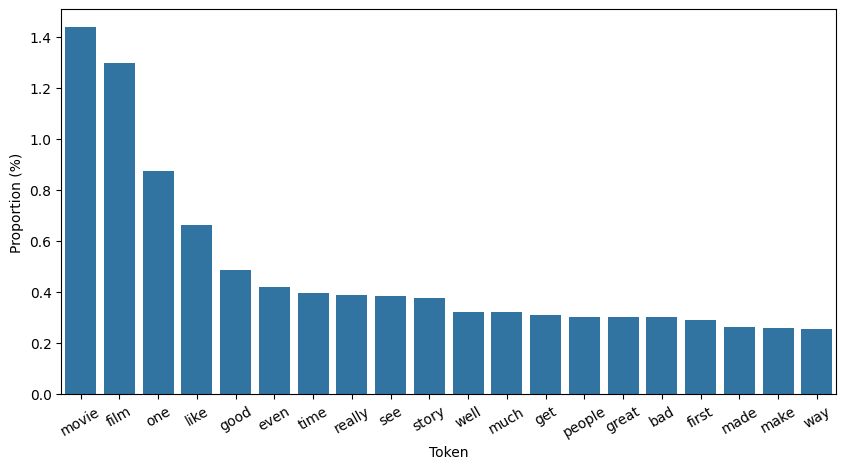

In [10]:
freqDist = nltk.FreqDist(tokens).most_common(20)
freqDist = pd.Series(dict(freqDist))
relFreqDist = 100*freqDist/len(tokens)

fig, ax = plt.subplots(figsize = (10, 5))
all_plot = sns.barplot(x = relFreqDist.index, y = relFreqDist.values, color = "tab:blue", ax = ax)
ax.set_xlabel("Token")
ax.set_ylabel("Proportion (%)")
plt.xticks(rotation = 30)
plt.show()

##### Split the dataset into training and test sets.

In [11]:
X = dataset[["review"]]
y = dataset[["sentiment"]]
xTrain, xTest, yTrain, yTest = train_test_split(X, y, train_size = 0.7, random_state = 1)

trainSet = pd.concat([xTrain, yTrain], axis = 1)
trainSet.head()

,review,sentiment
8950,"Just a note to add to the above comment. Fear of a Black Hat doesn't have the criminal who's image has been ripped off by the band, that's in CB4....",positive
38421,one of the worst films i have seen to date. Pathetic action scene and really bad acting also do not help. The only good point is Gary busey's part...,negative
19363,"Crossfire is one of those films from the Forties that is crying for a remake, if for no other reason than maybe it's time it should be done as ori...",positive
30157,The film begins with people on Earth discovering that their rocket to Mars had not been lost but was just drifting out in Space near out planet. W...,negative
14294,"This was a pretty good episode. Though no ""Trapped in the Closet"" or ""Cartoon Wars,"" it had a lot of things going for it. The character of Al Gore...",positive


In [12]:
testSet = pd.concat([xTest, yTest], axis = 1)
testSet.head()

,review,sentiment
26247,With No Dead Heroes you get stupid lines like that as this woefully abysmal action flick needs to be seen to be believed. William Sanders is saved...,negative
35067,I thought maybe... maybe this could be good. An early appearance by the Re-Animator (Jeffery Combs); many homage's to old horror movies; the Troma...,negative
34590,"An elite American military team which of course happens to include two good looking women and a guy who can't quite grasp teamwork, lots of bats, ...",negative
16668,"Ridiculous horror film about a wealthy man (John Carradine) dying and leaving everything to his four children, and his servants to be divided up e...",negative
12196,"Well, if you are one of those Katana's film-nuts (just like me) you sure will appreciate this metaphysical Katana swinging blood spitting samurai ...",positive


##### Convert `xTrain`, `xTest`, `yTrain`, and `yTest` to arrays.

In [13]:
xTrain = xTrain.review.values
xTest = xTest.review.values
yTrain = yTrain.sentiment.values
yTest = yTest.sentiment.values

$\hspace{1in}$

###### **Train and test classifiers using `scikit-learn`**

##### Extract features from the reviews in the training and test sets using TF-IDF.

In [14]:
vectorizer = TfidfVectorizer()
trainVectors = vectorizer.fit_transform(xTrain)
testVectors = vectorizer.transform(xTest)

##### List the classifiers to be trained.

In [15]:
classifiers = [("Decision Tree Classifier", DecisionTreeClassifier(random_state = 1)),
               ("k-Nearest Neighbors Classifier", KNeighborsClassifier()),
               ("Logistic Regression", LogisticRegression(random_state = 1)),
               ("Multinomial Naive Bayes Classifier", MultinomialNB()),
               ("Random Forest Classifier", RandomForestClassifier(random_state = 1)),
               ("Support Vector Classifier", SVC(random_state = 1))]

##### Train and test each classifier.

In [16]:
startTimeAll = time.time()

accuracyScores = []
for clfName, clf in classifiers:

    startTimeClassifier = time.time()
    print("\n Training and testing a %s ..." % clfName, end = " ")

    clf.fit(trainVectors, yTrain)
    predictions = clf.predict(testVectors)
    accuracyScore = accuracy_score(yTest, predictions)
    accuracyScores.append(accuracyScore)

    executionTimeClassifier = time.time() - startTimeClassifier

    if executionTimeClassifier < 60:
       print("Completed in %.2f seconds." % executionTimeClassifier)
    else:
       print("Completed in %.2f minutes." % (executionTimeClassifier/60))

executionTimeAll = time.time() - startTimeAll

if executionTimeAll < 60:
   print("\n Overall Execution Time = %.2f seconds" % executionTimeAll)
else:
   print("\n Overall Execution Time = %.2f minutes" % (executionTimeAll/60))


 Training and testing a Decision Tree Classifier ... Completed in 1.72 minutes.

 Training and testing a k-Nearest Neighbors Classifier ... Completed in 1.21 minutes.

 Training and testing a Logistic Regression ... Completed in 4.67 seconds.

 Training and testing a Multinomial Naive Bayes Classifier ... Completed in 0.19 seconds.

 Training and testing a Random Forest Classifier ... Completed in 2.97 minutes.

 Training and testing a Support Vector Classifier ... Completed in 70.20 minutes.

 Overall Execution Time = 76.18 minutes


##### Display the accuracy of each trained classifier on the test set.

In [17]:
clfNames = list(zip(*classifiers))[0]
dfAccuracyScores = pd.DataFrame({"classifier": clfNames,  "accuracy": accuracyScores})
dfAccuracyScores

,classifier,accuracy
0,Decision Tree Classifier,0.710533
1,k-Nearest Neighbors Classifier,0.763667
2,Logistic Regression,0.897933
3,Multinomial Naive Bayes Classifier,0.867400
4,Random Forest Classifier,0.847200
5,Support Vector Classifier,0.904467


$\hspace{1in}$

##### **Test a classifier using a pretrained model from Hugging Face.**

##### Build a classifier using a pretrained model.

In [18]:
modelName = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(modelName, clean_up_tokenization_spaces = True)
classifier = pipeline("sentiment-analysis", model = modelName, tokenizer = tokenizer, truncation = True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

##### Run the classifier on the test set.

In [19]:
startTime = time.time()
classifierOutput = classifier(list(xTest))
predictions = [x["label"].lower() for x in classifierOutput]
executionTime = time.time() - startTime

if executionTime < 60:
   print("\n Execution Time = %.2f seconds" % executionTime)
else:
   print("\n Execution Time = %.2f minutes" % (executionTime/60))


 Execution Time = 125.15 minutes


##### Calculate the accuracy of the classifier on the test set.

In [20]:
accuracy_score(yTest, predictions)

0.8888